In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, Input, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2025-08-11 14:21:10.184992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754922070.559464      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754922070.658996      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
BASE_DIR = {r'/kaggle/input/utkface-new/UTKFace'}
genderDict = {0:"Male",1:"Female"}

In [5]:
image = []
age = []
gender = []
for bd in BASE_DIR:
    for file in tqdm(os.listdir(bd)):
        temp = file.split('_')
        if temp[0].isdigit():
            age.append(int(temp[0]))
        if temp[1].isdigit():
            gender.append(int(temp[1]))
        image.append(os.path.join(bd,file))

100%|██████████| 23708/23708 [00:00<00:00, 515998.36it/s]


In [6]:
d = pd.DataFrame()
d['image'],d['age'],d['gender'] = image,age,gender
print(f"DataFrame: {d.head()}")
print(f"DataFrame shape: {d.shape}") 

DataFrame:                                                image  age  gender
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1
DataFrame shape: (23708, 3)


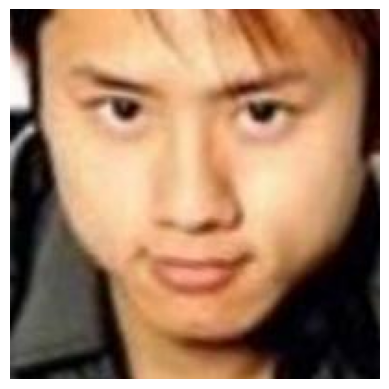

In [7]:
if (not d.empty):
    try:
        img = Image.open(d['image'][0])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(f"Error opening image - {e}")
else: print("Dataframe is empty")

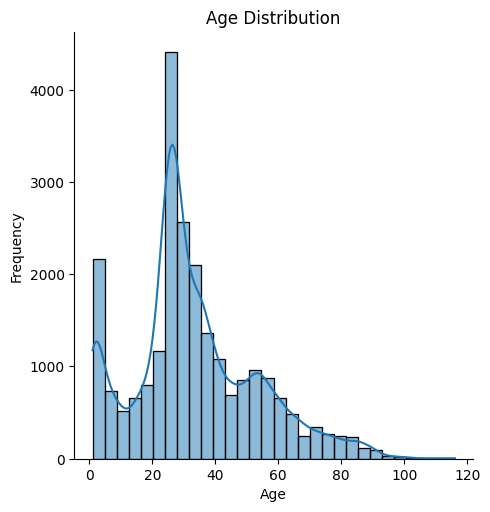

In [8]:
sns.displot(d['age'],kde=True,bins = 30)
plt.title("Age Distribution")
plt.ylabel("Frequency")
plt.xlabel("Age")
plt.show()

In [9]:
def feature_extract(images):
    feats = []
    for img in tqdm(images):
        img1 = Image.open(img).convert("L")
        img1 = img1.resize((128,128),Image.BILINEAR) #Image.NEAREST, Image.BICUBIC
        img_arr = np.array(img1)
        feats.append(img_arr)
    feats = np.array(feats)
    feats = feats.reshape(len(feats),128,128,1)
    return feats

In [10]:
x = feature_extract(d['image'])
print(f"Feature shape: {x.shape}")

100%|██████████| 23708/23708 [03:47<00:00, 104.36it/s]


Feature shape: (23708, 128, 128, 1)


In [11]:
x = x/255.0
age = np.array(age)
gender = np.array(gender)
print(f"X shape: {x.shape}")
print(f"Age shape: {age.shape}")
print(f"Gender shape: {gender.shape}")

X shape: (23708, 128, 128, 1)
Age shape: (23708,)
Gender shape: (23708,)


In [12]:
inp = Input((128,128,1)) #Creating input layer
#Creating nodes in CNN
cov1 = Conv2D(32,kernel_size = (3,3), activation = "relu")(inp)
mx1 = MaxPooling2D(pool_size = (2,2))(cov1)
cov2 = Conv2D(64,kernel_size = (3,3), activation = "relu")(mx1)
mx2 = MaxPooling2D(pool_size = (2,2))(cov2)
cov3 = Conv2D(128,kernel_size = (3,3), activation = "relu")(mx2)
mx3 = MaxPooling2D(pool_size = (2,2))(cov3)
cov4 = Conv2D(256,kernel_size = (3,3), activation = "relu")(mx3)
mx4 = MaxPooling2D(pool_size = (2,2))(cov4)
#Converting learned 3d feature map into 1d vector
flatten = Flatten()(mx4)
#Create decision making nodes, more dense nodes, better the model decision making on complex pattern
den1 = Dense(256,activation = 'relu')(flatten)
den2 = Dense(256,activation = 'relu')(flatten)
#Prevent overfitting, by randomly shutting nodes in CNN during training process
drpout1 = Dropout(0.3)(den1)
drpout2 = Dropout(0.3)(den2)
#Create output layer
op1 = Dense(1,activation = 'sigmoid',name = 'Gender')(drpout1)
op2 = Dense(1,activation = 'relu',name = 'Age')(drpout2)
#Model creation
model = Model(inputs = inp, outputs = [op1,op2])
model.summary()


I0000 00:00:1754922320.845860      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754922320.846589      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gender (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Age (Dense)         │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
y = np.column_stack((gender,age))
x_train,x_t,y_train,y_t = train_test_split(x,y,test_size = 0.2, random_state = 42)
x_test,x_val,y_test,y_val = train_test_split(x_t,y_t,test_size = 0.2,random_state = 42) #Splitting the remaining into test and validation set

y_gender_tr,y_age_tr = y_train[:,0],y_train[:,1]
y_gender_tt,y_age_tt = y_test[:,0],y_test[:,1]
y_gender_val,y_age_val = y_val[:,0],y_val[:,1]

In [ ]:
#Checkpointing model training
model_path = '/kaggle/working/gender_age_model.weights.h5'
chkptr = ModelCheckpoint(
    filepath = model_path,
    monitor = "val_Gender_accuracy",
    verbose = 1,
    mode = 'max',
    save_best_only = True
)

In [15]:
#Model Loss function
model.compile(loss = ['binary_crossentropy','mae'],
             optimizer = 'adam', metrics = ['accuracy','mae'])
annealer = LearningRateScheduler(lambda z:1e-3*0.9**z)

In [16]:
print(f"No. of images for training: {len(x_train)}")
print(f"No. of images for testing: {len(x_test)}")
print(f"No. of images for validation: {len(x_val)}")

No. of images for training: 18966
No. of images for testing: 3793
No. of images for validation: 949


In [17]:
tf.config.run_functions_eagerly(True)

In [37]:
#Model fitting
history = model.fit(
    x = x_train,
    y = [y_gender_tr,y_age_tr],
    batch_size = 128,
    epochs = 30,
    validation_data = (x_val,[y_gender_val,y_age_val]),
    callbacks = [annealer,chkptr]
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - Age_loss: 5.9347 - Age_mae: 5.9347 - Gender_accuracy: 0.9079 - Gender_loss: 0.2121 - loss: 6.1467
Epoch 1: val_Gender_accuracy improved from -inf to 0.89146, saving model to /kaggle/working/model1.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - Age_loss: 5.9345 - Age_mae: 5.9345 - Gender_accuracy: 0.9079 - Gender_loss: 0.2121 - loss: 6.1465 - val_Age_loss: 6.6807 - val_Age_mae: 6.6807 - val_Gender_accuracy: 0.8915 - val_Gender_loss: 0.2524 - val_loss: 6.9330 - learning_rate: 0.0010
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - Age_loss: 5.3969 - Age_mae: 5.3969 - Gender_accuracy: 0.9156 - Gender_loss: 0.2036 - loss: 5.6005
Epoch 2: val_Gender_accuracy improved from 0.89146 to 0.89779, saving model to /kaggle/working/model1.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - Age_loss: 5.3968 - Age_mae: 5.3968 - Gender_accuracy: 0.9156 - Gender_loss: 0.2036 - loss: 5.6005 - val_Age_loss: 6.8385 - val_Age_mae:

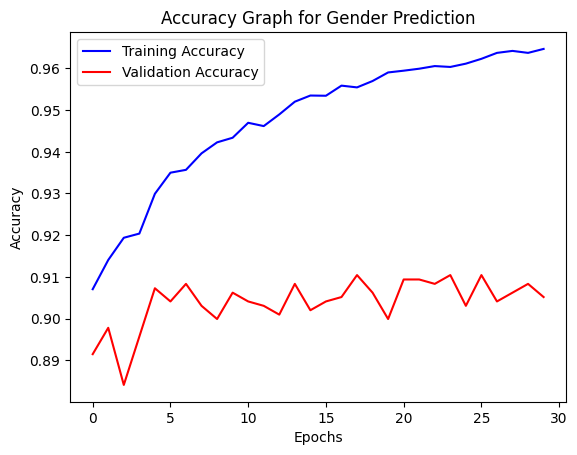

In [38]:
acc = history.history['Gender_accuracy']
val_acc = history.history['val_Gender_accuracy']
epochs = range(len(acc))
plt.plot(epochs,acc,'b',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'r',label = 'Validation Accuracy')
plt.title("Accuracy Graph for Gender Prediction")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

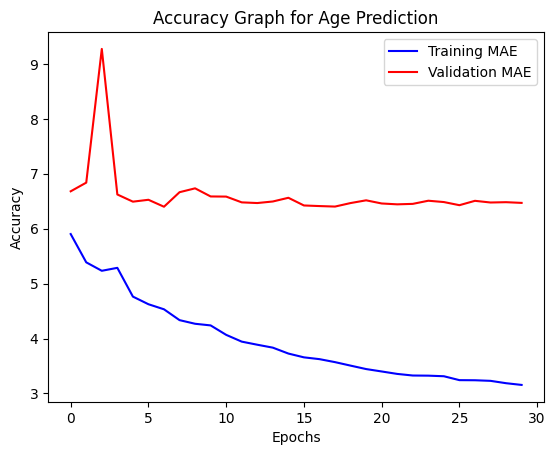

In [39]:
acc = history.history['Age_mae']
val_acc = history.history['val_Age_mae']
epochs = range(len(acc))
plt.plot(epochs,acc,'b',label = 'Training MAE')
plt.plot(epochs,val_acc,'r',label = 'Validation MAE')
plt.title("Accuracy Graph for Age Prediction")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
image_index = 3000
pred = model.predict(x[image_index].reshape(1,128,128,1))
pred_gen = genderDict[int(round(pred[0][0][0]))]
pred_age = round(pred[1][0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Original gender:Male	 Original age:28
Predicted gender:Male	 Predicted age:33


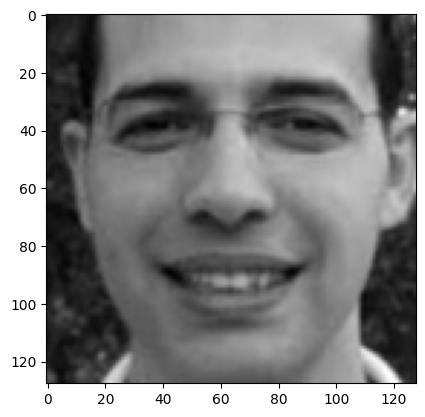

In [30]:
print(f"Original gender:{genderDict[gender[image_index]]}\t Original age:{age[image_index]}")
print(f"Predicted gender:{pred_gen}\t Predicted age:{pred_age}")
plt.imshow(x[image_index].reshape(128,128),cmap = 'gray')
plt.show()

In [31]:
image_index = 10000
pred = model.predict(x[image_index].reshape(1,128,128,1))
pred_gen = genderDict[int(round(pred[0][0][0]))]
pred_age = round(pred[1][0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Original gender:Male	 Original age:42
Predicted gender:Male	 Predicted age:42


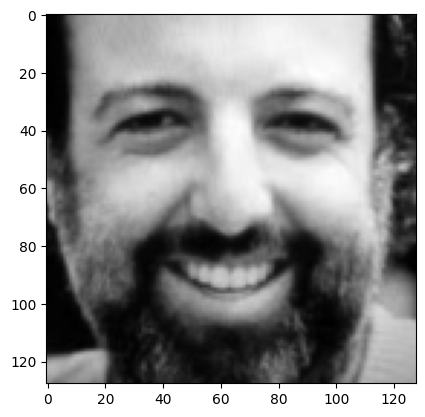

In [32]:
print(f"Original gender:{genderDict[gender[image_index]]}\t Original age:{age[image_index]}")
print(f"Predicted gender:{pred_gen}\t Predicted age:{pred_age}")
plt.imshow(x[image_index].reshape(128,128),cmap = 'gray')
plt.show()

In [33]:
image_index = 50
pred = model.predict(x[image_index].reshape(1,128,128,1))
pred_gen = genderDict[int(round(pred[0][0][0]))]
pred_age = round(pred[1][0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Original gender:Female	 Original age:22
Predicted gender:Female	 Predicted age:27


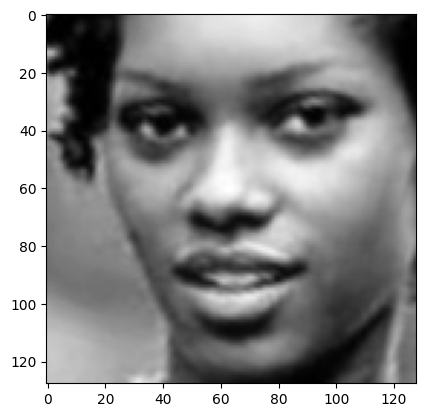

In [34]:
print(f"Original gender:{genderDict[gender[image_index]]}\t Original age:{age[image_index]}")
print(f"Predicted gender:{pred_gen}\t Predicted age:{pred_age}")
plt.imshow(x[image_index].reshape(128,128),cmap = 'gray')
plt.show()

In [ ]:
model.save('/kaggle/working/gender_age_model.h5')